# Project Report TDT4173

Kaggle Team Name: `[7] Material Girls`

Team Members:
- [564323] Eirill Bue
- [544590] Nora Langfeldt Borgenvik
- [586744] Silje Holm Johannesen

In [74]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Base path for datasets
data_path = "data"

# Load data
receivals = pd.read_csv(f"{data_path}/kernel/receivals.csv")
purchase_orders = pd.read_csv(f"{data_path}/kernel/purchase_orders.csv")
materials = pd.read_csv(f"{data_path}/extended/materials.csv")
transportation = pd.read_csv(f"{data_path}/extended/transportation.csv")

# Convert date columns to datetime
receivals["date_arrival"] = pd.to_datetime(receivals["date_arrival"], utc=True)
purchase_orders["delivery_date"] = pd.to_datetime(purchase_orders["delivery_date"], utc=True)
purchase_orders["created_date_time"] = pd.to_datetime(purchase_orders["created_date_time"], utc=True)
purchase_orders["modified_date_time"] = pd.to_datetime(purchase_orders["modified_date_time"], utc=True)

# **Exploratory Data Analysis**

## 1. Search Domain Knowledge

- Use understanding of operations to guide the analysis.  
- Check for seasonality: are some materials delivered only at certain times?  
- Examine supplier behavior: do certain suppliers consistently underdeliver or deliver irregularly?  
- Consider batch splitting: how are deliveries divided into multiple batches per order?  

### Overview

Hydro orders materials with an expected delivery date; shipments may be transported by a carrier and are finally received at site. The receipt event records *when* the material arrived and *how much* material was actually delivered (net of packaging). This receipt event is the ground truth for arrivals and quantities.  

### Data flow (real world)

1. An order specifies product and quantity, with an expected delivery date.  
2. (Sometimes) a transport leg occurs, handled by a carrier/vehicle.  
3. One or more partial deliveries arrive; each arrival is logged with its date/time and net material weight.  

### How the data links together

Orders and arrivals connect through shared identifiers; one ordered item can be fulfilled by several partial deliveries. Transport records (when available) can be linked to those deliveries, and material metadata enriches the context (e.g., alloy or format).  

### Timelines and measures we rely on

- **Arrival date** (in UTC) marks the day the material actually counts as received.  
- **Expected date** comes from the order and can sometimes be a placeholder (e.g., end-of-month/year).  
- **Delay** is defined as arrival date minus expected date (positive = late, negative = early).  
- **Fulfilment** compares total received weight to the ordered quantity for each ordered item.  

### Why this matters for our forecast

We forecast cumulative incoming material (net weight) over the Jan–May 2025 window using history up to end-2024. The evaluation uses a 0.2 quantile loss that penalizes overestimation much more than underestimation, so we bias features and baselines toward conservative estimates—especially where delays, split deliveries, or transport effects increase risk.


## 2. Check if the Data is Intuitive

The goal of this step is to verify that the data behaves logically and aligns with what we would expect from real-world raw material deliveries and purchase orders.
We focus on detecting inconsistencies, impossible values, and structural issues that might indicate data quality problems before modeling.

### 2.1 - Check for Physically Impossible Values

We start by identifying values that are not physically possible, such as negative or zero weights and quantities. Such values could indicate measurement errors, placeholder values, or incorrect data entry.

We focus on the following columns from each dataset:

- **Receivals:** `net_weight`
- **Purchase Orders:** `quantity`
- **Transportation:** `net_weight`, `gross_weight`, `tare_weight`, `vehicle_start_weight` and `vehicle_end_weight`
- **Transportation:**  
  `net_weight`, `gross_weight`, `tare_weight`, `vehicle_start_weight`, `vehicle_end_weight`,  
  `wood`, `ironbands`, `plastic`, `water`, `ice`, `other`, `chips`, `packaging` and `cardboard` 


In [75]:
# Function to count zeros and negatives per dataset
def count_dataset_anomalies(df, columns, name):
    for col in columns:
        if col in df.columns:
            num_zero = (df[col] == 0).sum()
            num_negative = (df[col] < 0).sum()
            total = num_zero + num_negative
            print(f"{col}: {total} non-positive values ({num_zero} zero, {num_negative} negative)")

# Columns to check per dataset
receivals_cols = ['net_weight']
purchase_orders_cols = ['quantity']
transportation_cols = [
    'net_weight', 'gross_weight', 'tare_weight', 'vehicle_start_weight', 'vehicle_end_weight',
    'wood', 'ironbands', 'plastic', 'water', 'ice', 'other', 'chips', 'packaging', 'cardboard'
]

# Run anomaly counts
count_dataset_anomalies(receivals, receivals_cols, "Receivals")
count_dataset_anomalies(purchase_orders, purchase_orders_cols, "Purchase Orders")
count_dataset_anomalies(transportation, transportation_cols, "Transportation")

net_weight: 137 non-positive values (137 zero, 0 negative)
quantity: 10 non-positive values (4 zero, 6 negative)
net_weight: 137 non-positive values (137 zero, 0 negative)
gross_weight: 124 non-positive values (124 zero, 0 negative)
tare_weight: 63844 non-positive values (63844 zero, 0 negative)
vehicle_start_weight: 0 non-positive values (0 zero, 0 negative)
vehicle_end_weight: 44 non-positive values (44 zero, 0 negative)
wood: 1110 non-positive values (1110 zero, 0 negative)
ironbands: 6870 non-positive values (6870 zero, 0 negative)
plastic: 6126 non-positive values (6126 zero, 0 negative)
water: 7784 non-positive values (7784 zero, 0 negative)
ice: 7786 non-positive values (7786 zero, 0 negative)
other: 8207 non-positive values (7738 zero, 469 negative)
chips: 7774 non-positive values (7774 zero, 0 negative)
packaging: 6458 non-positive values (6456 zero, 2 negative)
cardboard: 7767 non-positive values (7767 zero, 0 negative)


From the output above, we can see that all examined columns have some zero or negative values. 

**Negative values** are very rare across the datasets. In the `Purchase Orders` dataset, a few entries have negative quantities, and in the `Transportation` dataset, only a handful of entries in other and packaging are negative. Since these negative values are so few, they can be safely removed from the datasets without affecting the analysis.

**Zero values** are more frequent and likely indicate missing measurements, placeholder entries, or cases where no material was recorded. These will need to be addressed in the Data Preparation phase to ensure accurate analysis.

Since `net_weight` is our target variable, we want to understand more about the zero values.

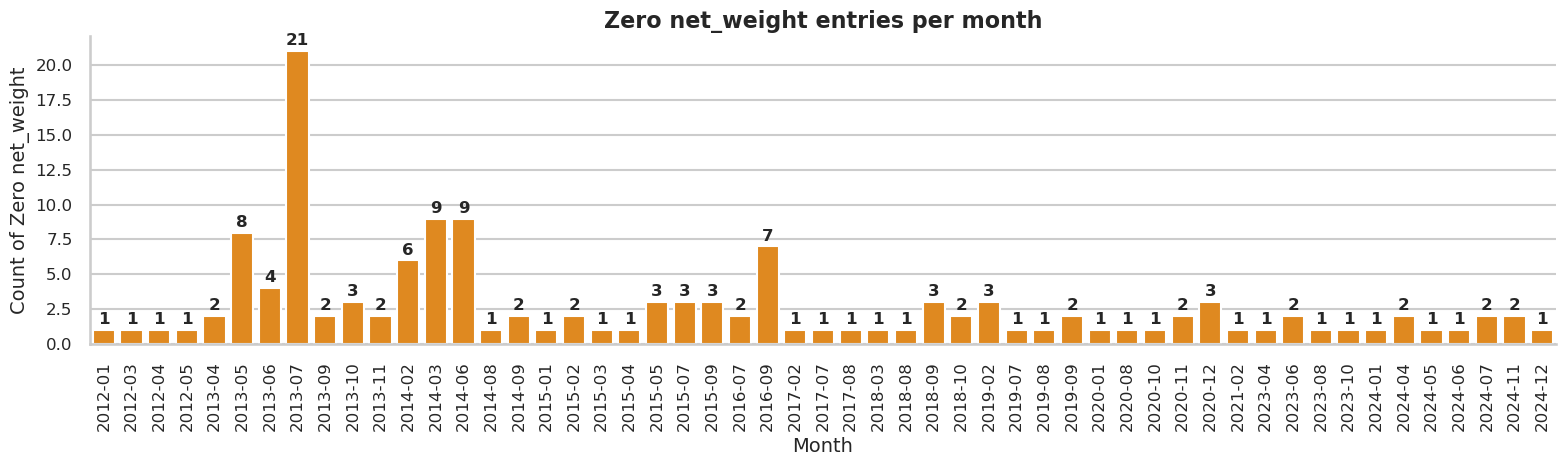

In [76]:
zero_net_weight = receivals[receivals['net_weight'] == 0].copy()
zero_net_weight['date_arrival_local'] = zero_net_weight['date_arrival'].dt.tz_convert(None)
zero_net_weight['month'] = zero_net_weight['date_arrival_local'].dt.to_period('M')
monthly_counts = zero_net_weight.groupby('month').size().reset_index(name='count')

plt.figure(figsize=(16,5))
sns.barplot(
    data=monthly_counts,
    x='month',
    y='count',
    color='darkorange'
)
plt.title('Zero net_weight entries per month', weight='bold', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count of Zero net_weight', fontsize=14)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

for i, v in enumerate(monthly_counts['count']):
    plt.text(i, v + max(monthly_counts['count'])*0.01, str(v), ha='center', va='bottom', fontsize=12, weight='bold')

sns.despine()
plt.tight_layout()
plt.show()

We plot the zero `net_weight` entries aggregated by month to understand their temporal distribution. While there are 137 zero values in total, they are relatively evenly distributed across the years, with a slight concentration in July 2013. Since `net_weight` is our target variable, these entries would provide incorrect information for predicting it and should therefore be removed. Keeping them would likely degrade prediction quality and introduce noise into the model.

### 2.2 - Check Unit Consistency

Next, we verify that all units are expressed consistently across records.
For example, we ensure that all weights use the same measurement unit (e.g., kilograms) and that no mix of units (such as kg, ton, or g) exists.
We will also check for missing or malformed unit entries and decide whether these records can be trusted.

The `purchase_orders` table contains the unit information (`unit` and `unit_id`) for all orders. To check if all entries are expressed consistently:

- We count how many entries there are for each unit.  
- We check if any `unit_id` maps to more than one unit, which would indicate inconsistent unit assignments.  
- We check if any `product_id` has more that one unit.

In [77]:
unit_counts = purchase_orders['unit'].value_counts()
print("Number of entries per unit:")
print(unit_counts)

unit_inconsistency = purchase_orders.groupby('unit_id')['unit'].nunique()
num_inconsistent_unit_ids = (unit_inconsistency > 1).sum()
print("\nNumber of unit_ids mapping to more than one unit:", num_inconsistent_unit_ids)

units_per_product = purchase_orders.groupby('product_id')['unit'].unique()
products_multiple_units = units_per_product[units_per_product.apply(lambda x: len(x) > 1)]
print("\nProducts with more than one unit type:")
print(products_multiple_units)

prod_1414_units = purchase_orders[purchase_orders['product_id'] == 1414.0]['unit'].value_counts()
print("\nNumber of entries per unit for product 1414.0:")
print(prod_1414_units)


Number of entries per unit:
unit
KG      33120
PUND        7
Name: count, dtype: int64

Number of unit_ids mapping to more than one unit: 0

Products with more than one unit type:
product_id
1414        [KG, PUND]
91900143     [nan, KG]
91900160     [nan, KG]
91900170     [nan, KG]
91900296     [nan, KG]
91901050     [nan, KG]
91901460     [nan, KG]
Name: unit, dtype: object

Number of entries per unit for product 1414.0:
unit
KG      23
PUND     7
Name: count, dtype: int64


As we can see from the data, almost all entries are in KG, and only a few entries are in PUND.  

A few products have missing units (NaN), but only `product_id` 1414 has entries in both KG and PUND. In the data preparation, we will convert all quantities to a consistent unit, kilograms.  This ensures that all quantities are comparable and consistent for further analysis.

### 2.3 - Check Temporal Consistency

We then confirm that all date fields follow logical order and fall within reasonable time frames. This involves checking that:

- Created purchase order dates are not after arrival dates.
- No timestamps are in the future (after 31st of December 2024).
- Date formats and time zones are consistent across tables.

In [78]:
merged = receivals.merge(
    purchase_orders[['purchase_order_id', 'purchase_order_item_no', 'created_date_time']],
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left'
)

# Check if arrival happens before purchase order was created
arrival_before_creation = merged[merged['date_arrival'] < merged['created_date_time']]
print("Number of receivals arriving before purchase order creation:", len(arrival_before_creation))

# Check for future dates after 31st December 2024
cutoff_date = pd.Timestamp("2024-12-31", tz="UTC")

receivals_future = receivals[receivals['date_arrival'] > cutoff_date]
po_future_created = purchase_orders[purchase_orders['created_date_time'] > cutoff_date]

print("Receivals - entries with date_arrival after 2024-12-31:", len(receivals_future))
print("Purchase Orders - created_date_time after 2024-12-31:", len(po_future_created))


# Total number of receivals
total_receivals = len(receivals)
print("\nTotal number of receivals:", total_receivals)

# Number of receivals arriving before purchase order creation
arrival_before_creation = merged[merged['date_arrival'] < merged['created_date_time']]
num_before_creation = len(arrival_before_creation)
print("Number of receivals arriving before purchase order creation:", num_before_creation)

# Percentage
percent = num_before_creation / total_receivals * 100
print(f"Percentage of receivals affected: {percent:.2f}%")


Number of receivals arriving before purchase order creation: 4694
Receivals - entries with date_arrival after 2024-12-31: 0
Purchase Orders - created_date_time after 2024-12-31: 0

Total number of receivals: 122593
Number of receivals arriving before purchase order creation: 4694
Percentage of receivals affected: 3.83%


We examined the temporal consistency of the datasets to ensure that date fields follow a logical order and remain within a valid time range. No receivals or purchase orders have timestamps beyond 31st December 2024, meaning the data does not contain future or implausible dates.

Furthermore, out of all receivals, 3.83% of them have an arrival date that occurs before the corresponding purchase order was created. This indicates a small number of inconsistencies where the recorded creation timestamp likely does not reflect the actual order initiation date. To better understand the temporal inconsistencies identified, we visualize the affected receivals by year, as well as the top products and suppliers involved. These plots will help highlight patterns and guide further investigation into the underlying causes.

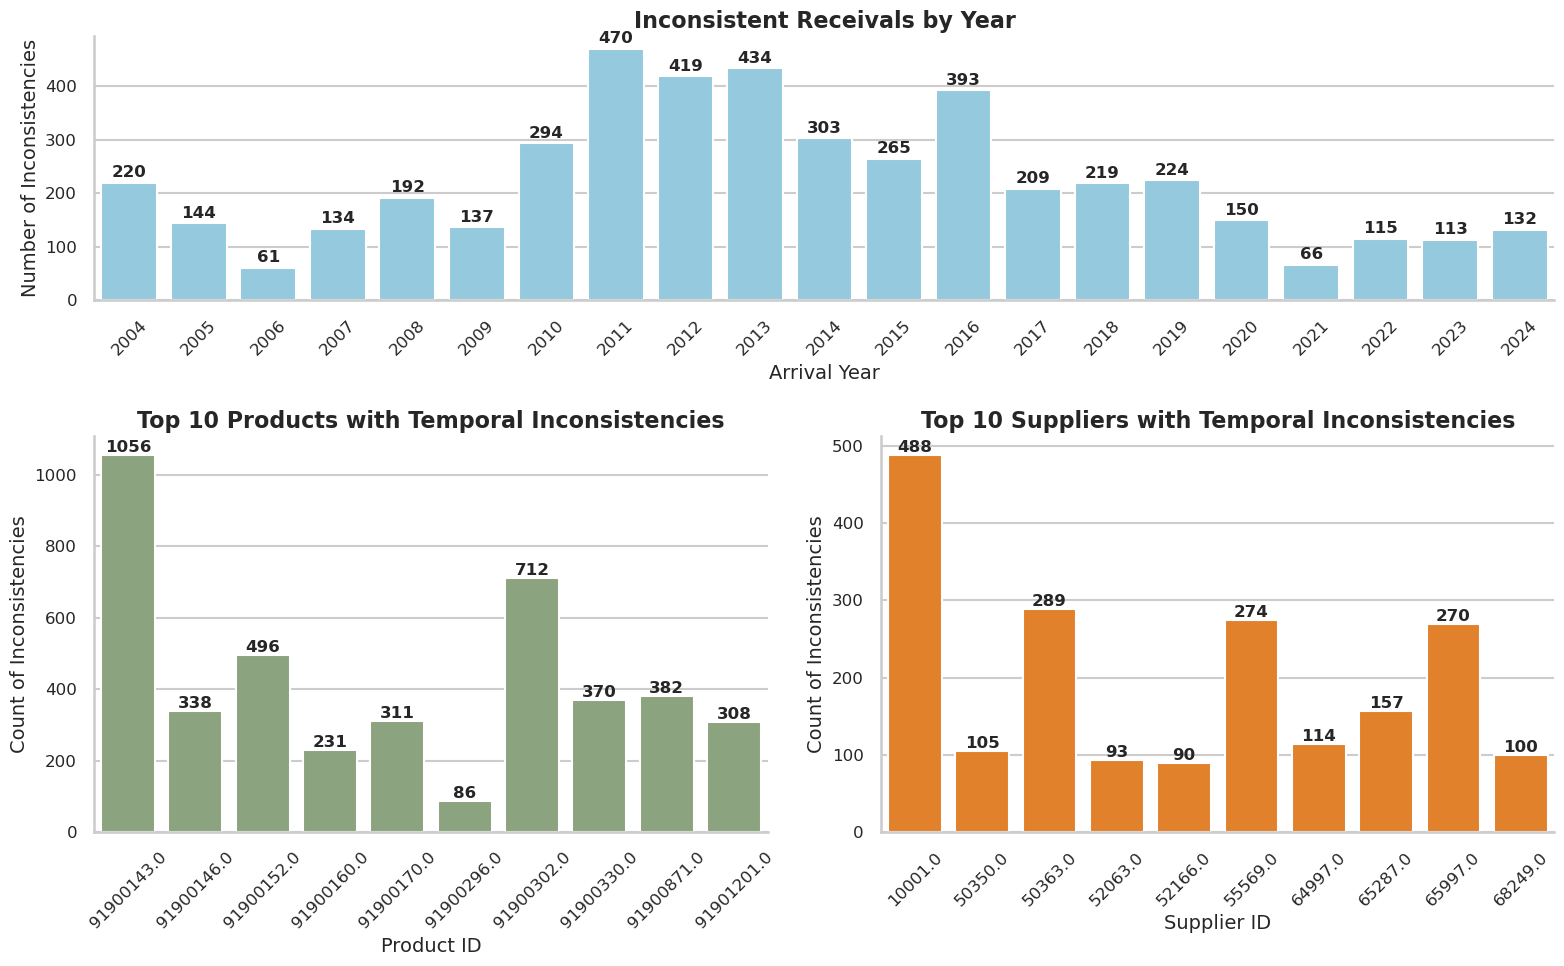

In [79]:
from matplotlib.gridspec import GridSpec

merged = receivals.merge(
    purchase_orders[['purchase_order_id', 'purchase_order_item_no', 'created_date_time']],
    on=['purchase_order_id', 'purchase_order_item_no'],
    how='left'
)

inconsistent = merged[merged['date_arrival'] < merged['created_date_time']].copy()
inconsistent.loc[:, "arrival_year"] = inconsistent["date_arrival"].dt.year

sns.set_theme(style="whitegrid", context="talk", font="DejaVu Sans")
plt.rcParams.update({'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 12, 'ytick.labelsize': 12})

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 3], width_ratios=[1, 1], figure=fig)

# Graph 1
ax0 = fig.add_subplot(gs[0, :])
year_counts = inconsistent["arrival_year"].value_counts().sort_index()
sns.barplot(
    x=year_counts.index,
    y=year_counts.values,
    color="#87CEEB",  # skyblue
    ax=ax0
)
ax0.set_title("Inconsistent Receivals by Year", weight="bold")
ax0.set_xlabel("Arrival Year")
ax0.set_ylabel("Number of Inconsistencies")
ax0.tick_params(axis="x", rotation=45)

for i, v in enumerate(year_counts.values):
    ax0.text(i, v + max(year_counts.values)*0.01, str(v), ha='center', va='bottom', fontsize=12, weight='bold')

# Graph 2
top_products = inconsistent["product_id"].value_counts().head(10).reset_index()
top_products.columns = ["product_id", "count"]
top_products["count"] = top_products["count"].astype(int)

ax1 = fig.add_subplot(gs[1, 0])
sns.barplot(
    data=top_products,
    x="product_id",
    y="count",
    color="#89a978",
    ax=ax1
)
ax1.set_title("Top 10 Products with Temporal Inconsistencies", weight="bold")
ax1.set_xlabel("Product ID")
ax1.set_ylabel("Count of Inconsistencies")
ax1.tick_params(axis="x", rotation=45)

for p in ax1.patches:
    ax1.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=12,
        weight='bold'
    )

# Graph 3
top_suppliers = inconsistent["supplier_id"].value_counts().head(10).reset_index()
top_suppliers.columns = ["supplier_id", "count"]
top_suppliers["count"] = top_suppliers["count"].astype(int)

ax2 = fig.add_subplot(gs[1, 1])
sns.barplot(
    data=top_suppliers,
    x="supplier_id",
    y="count",
    color="#ff7f0e",
    ax=ax2
)
ax2.set_title("Top 10 Suppliers with Temporal Inconsistencies", weight="bold")
ax2.set_xlabel("Supplier ID")
ax2.set_ylabel("Count of Inconsistencies")
ax2.tick_params(axis="x", rotation=45)

for p in ax2.patches:
    ax2.annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=12,
        weight='bold'
    )

sns.despine()
plt.tight_layout()
plt.show()


To handle these issues, all inconsistent receivals will be flagged during the data preparation phase. We will investigate whether the recorded arrival or creation dates are incorrect and either correct them if possible or exclude the affected entries from further analysis to ensure temporal integrity.

### 2.4 - Check ID Consistency and Structure

We ensure that all identifiers, such as purchase_order_id, product_id, and supplier_id, are positive integers and behave consistently over time.
This includes checking whether any IDs appear to change unexpectedly, for example, if a material or supplier seems to get a new ID from one year to the next.
Such cases could indicate changes in the underlying data system or joining keys that require standardization later.

In [80]:
# Work on copies to avoid modifying original data
rec = receivals.copy()
po = purchase_orders.copy()
mat = materials.copy()
trans = transportation.copy()

# Define ID columns per table
id_columns = {
    "receivals": ["rm_id", "product_id", "purchase_order_id", "purchase_order_item_no", "batch_id", "receival_item_no", "supplier_id"],
    "purchase_orders": ["purchase_order_id", "purchase_order_item_no", "product_id", "product_version", "unit_id", "status_id"],
    "materials": ["rm_id", "product_id", "product_version"],
    "transportation": ["rm_id", "product_id", "purchase_order_id", "purchase_order_item_no", "receival_item_no", "batch_id"]
}

# Check for negative IDs
for table_name, cols in id_columns.items():
    print(f"\nTable: {table_name}")
    df = locals()[table_name]
    for col in cols:
        if col in df.columns:
            negative_ids = df[df[col] < 0]
            print(f"{col}: {len(negative_ids)} negative entries")


Table: receivals
rm_id: 0 negative entries
product_id: 0 negative entries
purchase_order_id: 0 negative entries
purchase_order_item_no: 0 negative entries
batch_id: 0 negative entries
receival_item_no: 0 negative entries
supplier_id: 0 negative entries

Table: purchase_orders
purchase_order_id: 0 negative entries
purchase_order_item_no: 0 negative entries
product_id: 0 negative entries
product_version: 0 negative entries
unit_id: 0 negative entries
status_id: 0 negative entries

Table: materials
rm_id: 0 negative entries
product_id: 0 negative entries
product_version: 0 negative entries

Table: transportation
rm_id: 0 negative entries
product_id: 0 negative entries
purchase_order_id: 0 negative entries
purchase_order_item_no: 0 negative entries
receival_item_no: 0 negative entries
batch_id: 0 negative entries


All ID fields across the four datasets (receivals, purchase_orders, materials, and transportation) contain only positive values. This suggests that the identifier structure is valid and no corrupted or placeholder IDs.

However, while the IDs are numerically valid, there may still be semantic inconsistencies. For example, if a material (identified by rm_id) appears to have been assigned a new ID in later years, or if the same material name or description maps to multiple IDs. Such changes could indicate updates or restructuring in the underlying system.

To explore this, we can check whether materials with the same rm_id are associated with different names over time.

In [81]:
import pandas as pd

# Merge receivals with material info to connect rm_id and raw_material_alloy
merged_materials = receivals.merge(
    materials[['rm_id', 'product_id', 'raw_material_alloy']],
    on=['rm_id', 'product_id'],
    how='left'
)

# 1. Number of raw materials with multiple rm_ids
multiple_ids_per_alloy = (
    merged_materials.groupby('raw_material_alloy')['rm_id']
    .nunique()
    .loc[lambda x: x > 1]
)
num_raw_materials_multiple_rmids = multiple_ids_per_alloy.shape[0]
print("Number of raw materials with multiple rm_ids:", num_raw_materials_multiple_rmids)

# 2. Number of rm_ids linked to multiple raw material names
multiple_alloys_per_rm = (
    merged_materials.groupby('rm_id')['raw_material_alloy']
    .nunique()
    .loc[lambda x: x > 1]
)
num_rmids_multiple_alloys = multiple_alloys_per_rm.shape[0]
print("Number of rm_ids linked to multiple alloys:", num_rmids_multiple_alloys)

# 3. Prepare summary table for all rm_id → alloys (flag only if multiple alloys)
summary = []
for rm_id in merged_materials['rm_id'].unique():
    subset = merged_materials[merged_materials['rm_id'] == rm_id]
    alloys = subset['raw_material_alloy'].unique()
    
    # Flag only if more than one alloy
    if len(alloys) > 1:
        # Check if all alloys have identical arrival dates
        timeline = subset.groupby('raw_material_alloy')['date_arrival'].agg(['min', 'max'])
        same_dates = timeline.nunique().eq(1).all()
        if same_dates:
            flag = 'naming inconsistency'
        else:
            flag = 'possible real change'
    else:
        flag = None

    summary.append({
        'rm_id': rm_id,
        'alloys': list(alloys),
        'flag': flag,
    })

summary_df = pd.DataFrame(summary)

# Only display rm_ids linked to multiple alloys with a flag
multi_alloy_summary = summary_df[summary_df['flag'].notna()]

display(multi_alloy_summary)


Number of raw materials with multiple rm_ids: 34
Number of rm_ids linked to multiple alloys: 24


,rm_id,alloys,flag
66,2131.0,"[CPS Prof 6060 Lacado, CPS 6060 (lacado)]",naming inconsistency
68,2132.0,"[CPS Prof 6060 Anodized, CPS 6060 (anodizado)]",naming inconsistency
69,2145.0,"[CPS Prof 6005, CPS 6005]",naming inconsistency
73,2143.0,"[CPS Prof 6060 Anodized, CPS 6060 (anodizado)]",naming inconsistency
74,2142.0,"[CPS Prof 6060 Lacado, CPS 6060 (lacado)]",naming inconsistency
76,2130.0,"[CPS Prof 6060, CPS 6060]",naming inconsistency
77,2135.0,"[CPS Prof 6082, CPS 6082]",naming inconsistency
81,2134.0,"[CPS Prof 6005, CPS 6005]",naming inconsistency
83,2144.0,"[CPS Prof 6060 Thermal Break, CPS 6060 (puente...",naming inconsistency
89,2133.0,"[CPS Prof 6060 Thermal Break, CPS 6060 (puente...",naming inconsistency


We analyzed the relationship between raw materials (`rm_id`s) and their alloy names (`raw_material_alloy`) to detect inconsistencies or potential changes in material usage.

- Alloys linked to multiple `rm_id`s were counted to detect duplicates recorded under different IDs.
- `rm_id`s linked with multiple alloy names were flagged for potential naming inconsistencies.
- For `rm_id`s with multiple alloy names, we compared the arrival dates:
   - If the date ranges overlapped, it suggests the same material was recorded with different names. This is flagged as **naming inconsistency**.
   - If the date ranges did not overlap, it suggests a possible material change over time. This is flagged as **possible real change**.
- We compiled a summary table showing each `rm_id`, its associated alloy names, and the corresponding flag. This table allows us to quickly identify which materials have naming issues and which might represent actual changes.


**Findings:**

- **Raw materials linked to multiple `rm_id`s:** 34  
- **`rm_id`s linked to multiple alloy names:** 24  
- Among these, most were naming inconsistencies, but one `rm_id` stood out as a **possible real change**, indicating that the material might have genuinely changed over time.


**Next steps:**

- For the possible real change, we will update the record to a single alloy for that `rm_id`.
- For naming inconsistencies, we will keep the `rm_id`s separate for now, rather than standardizing the alloy names. This is important because predictions are made per `rm_id`, and merging or renaming would make the predictions identical for different `rm_id`s, which could distort the results. We should, however, document the inconsistencies for reference and future review.

In [82]:
alloy_counts = materials.groupby('raw_material_alloy')['rm_id'].nunique()
top_alloy = alloy_counts.idxmax()

top_alloy_rm_ids = materials[materials['raw_material_alloy'] == top_alloy]['rm_id'].unique()

pm_data = receivals[receivals['rm_id'].isin(top_alloy_rm_ids)]

summary = pm_data.groupby('rm_id').agg(
    min_date=('date_arrival', 'min'),
    max_date=('date_arrival', 'max'),
    count_receivals=('receival_item_no', 'count'),
    avg_net_weight=('net_weight', 'mean')
).reset_index()

summary['alloy_name'] = top_alloy

summary


,rm_id,min_date,max_date,count_receivals,avg_net_weight,alloy_name
0,2128.0,2012-01-17 12:11:00+00:00,2012-01-17 12:11:00+00:00,1,24960.000000,"PM 99,7"
1,2140.0,2011-11-15 08:27:00+00:00,2024-09-03 11:39:00+00:00,5343,24801.211679,"PM 99,7"
2,3761.0,2023-02-15 07:43:00+00:00,2024-02-28 10:41:00+00:00,76,23931.092105,"PM 99,7"
3,3762.0,2023-06-05 13:16:00+00:00,2023-06-09 09:57:00+00:00,10,23140.000000,"PM 99,7"
4,4441.0,2024-09-27 08:50:00+00:00,2024-10-28 13:50:00+00:00,7,24942.857143,"PM 99,7"
5,4443.0,2024-09-04 10:01:00+00:00,2024-09-27 07:36:00+00:00,20,24749.000000,"PM 99,7"


We also computed a table for an example alloy associated with several rm_ids to examine their receival histories. From this table, we can see that:

- The different rm_ids have varying date ranges and numbers of receivals.
- The average net weights are quite similar across rm_ids, indicating that the material itself is consistent.

This suggests that we might be able to aggregate these receivals for prediction purposes, as the target variable is comparable despite differences in timing and number of entries.

In [83]:
# Merge receivals with materials to get alloy info
receivals_with_alloy = receivals.merge(
    materials[['rm_id', 'raw_material_alloy']],
    on='rm_id',
    how='left'
)

# 1. Count receivals per rm_id
receival_counts = receivals_with_alloy.groupby('rm_id').agg(
    count_receivals=('receival_item_no', 'count')
).reset_index()

# 2. Count unique alloys per rm_id
alloys_per_rm = receivals_with_alloy.groupby('rm_id')['raw_material_alloy'].nunique().reset_index()
alloys_per_rm = alloys_per_rm.rename(columns={'raw_material_alloy': 'num_alloys'})

# 3. Get the actual alloy name(s) for each rm_id
alloy_names = receivals_with_alloy.groupby('rm_id')['raw_material_alloy'].unique().reset_index()

# 4. Count how many rm_ids share each alloy
alloy_rm_counts = receivals_with_alloy.groupby('raw_material_alloy')['rm_id'].nunique().reset_index()
alloy_rm_counts = alloy_rm_counts.rename(columns={'rm_id': 'num_rm_ids'})

# 5. Merge everything together
low_count_table = receival_counts.merge(alloys_per_rm, on='rm_id') \
                                 .merge(alloy_names, on='rm_id') \
                                 .explode('raw_material_alloy') \
                                 .merge(alloy_rm_counts, on='raw_material_alloy')

# 6. Filter for rm_ids with fewer than 2 receivals
low_count_table = low_count_table[low_count_table['count_receivals'] < 2]

# Display the full table
display(low_count_table)



,rm_id,count_receivals,num_alloys,raw_material_alloy,num_rm_ids
0,342.0,1,1,SB06 Traders,1
1,343.0,1,1,SB02 606035,1
2,345.0,1,1,SA10 606035,1
8,355.0,1,1,"PM99,7 Coils",1
19,374.0,1,1,SB07 Lacado,1
30,390.0,1,1,SA23 anodizado,1
33,1844.0,1,1,"CS Al 99,5%",1
52,1882.0,1,1,PS606034CL Alto CuMn,1
65,2061.0,1,1,CS 6005 anodized,2
73,2128.0,1,1,"PM 99,7",6


In this table, we focus on rm_ids with only one receival entry. For each of these:

- We check the associated alloy name.
- We check if the alloy name appears across multiple rm_ids.

If it does, it suggests these rm_ids represent the same material, and we could potentially use their receivals to get more data points for predictions.

If the alloy name is unique to that rm_id, there is no additional data to leverage, which poses a challenge for prediction since we have only a single receival for that material stream. This makes the prediction less reliable and highlights the limitation of working with very sparse data.

### 2.5 - Summarize Actions for Data Preparation

Finally, we summarize the issues identified in this step and outline the cleaning actions that will be performed during the Data Preparation phase.

1. **Physically impossible values**  
   - Negative values in weights and quantities are rare and can be safely removed.  
   - Zero values are more frequent, particularly in `net_weight`, which is the target variable. Since these entries provide incorrect information for predictions, they should be removed to avoid introducing noise and degrading model performance.

2. **Unit consistency**  
   - Units are mostly consistent, with almost all entries in kilograms.  
   - A few entries use PUND or have missing units. These will be converted to a consistent unit (kilograms) to ensure comparability across all records.

3. **Temporal consistency**  
   - A small percentage of receivals occur before the corresponding purchase order was created, indicating minor temporal inconsistencies.  
   - No dates exceed the current time frame.  
   - **Action:** Flag inconsistent entries for further investigation. Correct or exclude them to maintain temporal integrity.

4. **ID consistency and structure**  
   - All identifier fields contain positive integers, suggesting no corrupted IDs.  
   - Semantic inconsistencies may exist, e.g., a single material assigned multiple `rm_id`s or multiple alloy names per `rm_id`.  
   - **Action:** Document naming inconsistencies and possible material changes. For possible real changes, standardize the alloy name for that `rm_id`. For naming inconsistencies, retain separate `rm_id`s to preserve prediction integrity.

5. **Materials linked to multiple `rm_id`s**  
   - Some alloys are associated with multiple `rm_id`s. Although receival dates and counts vary, the **average net weight is generally similar**, indicating the material itself is consistent.  
   - **Action:** When the target variable is comparable, we may aggregate data across `rm_id`s for predictions, increasing the number of usable data points.

6. **`rm_id`s with only a single receival**  
   - For each of these, we check the associated alloy name and whether it appears for multiple `rm_id`s.  
   - If the alloy appears across multiple `rm_id`s, we can leverage those additional receivals for predictions.  
   - If the alloy is unique to that `rm_id`, there is only a single receival available. This sparse data makes predictions less reliable and may require special handling, such as exclusion or careful imputation.

## 3. Understand How the Data Was Generated

### Receivals key uniqueness

In [ ]:
recv = receivals.copy()         

key_sets = [
    ["purchase_order_id", "purchase_order_item_no", "receival_item_no"],
    ["batch_id", "receival_item_no"]
]
for keys in key_sets:
    dup = recv.groupby(keys).size().gt(1).sum()
    total = recv.groupby(keys).ngroups
    print(f"{keys}: {dup} duplicate groups of {total} total ({dup/total:.2%} duplicates)")
    

['purchase_order_id', 'purchase_order_item_no', 'receival_item_no']: 18502 duplicate groups of 35680 total (51.86% duplicates)
['batch_id', 'receival_item_no']: 0 duplicate groups of 64765 total (0.00% duplicates)


Receival_item_no is not unique within a purchase order item. It likely resets per batch, or is reused when a purchase order item is split across batches/lines.

The pair [batch_id, receival_item_no] is unique. So receival_item_no seems to be scoped to the batch, not to the purchase order item. Use [batch_id, receival_item_no] as the primary key when aggregating or joining receivals.

In [ ]:
keys_bad = ["purchase_order_id","purchase_order_item_no","receival_item_no"]
dups = recv[recv.duplicated(keys_bad, keep=False)] \
        .sort_values(keys_bad)
cols = keys_bad + ["batch_id","date_arrival","rm_id","product_id","net_weight","receival_status"]
dups[cols].head(20)

,purchase_order_id,purchase_order_item_no,receival_item_no,batch_id,date_arrival,rm_id,product_id,net_weight,receival_status
41186,363.0,30.0,1.0,NaN,2012-07-06 13:01:00+00:00,2182.0,91901201.0,2380.0,Completed
41257,363.0,30.0,1.0,NaN,2012-07-12 12:36:00+00:00,2182.0,91901201.0,9160.0,Completed
416,206172.0,10.0,1.0,NaN,2004-07-19 08:36:00+00:00,367.0,91900143.0,11560.0,Completed
1191,206172.0,10.0,1.0,NaN,2004-10-13 06:47:00+00:00,365.0,91900143.0,25440.0,Completed
1414,206172.0,10.0,1.0,NaN,2004-10-28 15:25:00+00:00,365.0,91900143.0,18720.0,Completed
1996,206172.0,10.0,1.0,NaN,2004-12-12 23:22:00+00:00,365.0,91900143.0,17980.0,Completed
417,206172.0,20.0,2.0,NaN,2004-07-19 08:36:00+00:00,375.0,91900302.0,6900.0,Completed
1997,206172.0,20.0,2.0,NaN,2004-12-12 23:22:00+00:00,375.0,91900302.0,8340.0,Completed
2,208490.0,10.0,1.0,NaN,2004-06-15 11:38:00+00:00,365.0,91900143.0,11281.0,Completed
41,208490.0,10.0,1.0,NaN,2004-06-17 09:11:00+00:00,365.0,91900143.0,6287.0,Completed


Looking at sample rows, those duplicates have different arrival dates and/or different net weights. In other words, they’re partial deliveries for the same purchase order line, not accidental double entries.

Aggregate daily totals by the calendar day of date_arrival and by a material identifier (rm_id or product_id).
For a unique receival key, prefer [batch_id, receival_item_no]. If batch_id is missing, use [purchase_order_id, purchase_order_item_no, receival_item_no, date_arrival], and append a within-group sequence if duplicates remain.

### Link receivals and purchase orders

In [ ]:
recv2 = receivals.copy()
po = purchase_orders.copy()    

join_cols = ["purchase_order_id", "purchase_order_item_no"]
merged = recv2.merge(po[join_cols + ["quantity","delivery_date"]], on=join_cols, how="left")

tot   = len(merged)
unmatched = merged["quantity"].isna().sum()
matched   = tot - unmatched

print(f"Matched:   {matched:,}")
print(f"Unmatched: {unmatched:,}")
print(f"Total:     {tot:,}")

Matched:   122,537
Unmatched: 56
Total:     122,593


56 receival rows is not linked to a purchase order line.

### Planned vs actual delivery lag

In [ ]:
recv3 = receivals.copy()
po2 = purchase_orders.copy()    

lag_df = recv3.merge(po2[join_cols + ["delivery_date"]], on=join_cols, how="left")
lag = (lag_df["date_arrival"] - lag_df["delivery_date"]).dt.days.dropna()
if len(lag):
    print(f"Count={len(lag):,}, Median={lag.median():.1f}, p25={lag.quantile(0.25):.1f}, p75={lag.quantile(0.75):.1f}, p95={lag.quantile(0.95):.1f}")
    print(f"Late={100*(lag>0).mean():.1f}%, Early={100*(lag<0).mean():.1f}%, On-time={100*(lag==0).mean():.1f}%")
else:
    print("Not enough valid dates.")

Count=122,537, Median=-15.0, p25=-26.0, p75=-4.0, p95=9.0
Late=8.1%, Early=88.9%, On-time=3.0%


The majority of the arrival date beat the expected date by 1–4 weeks, and very few land exactly on it.
Late receipts are a minority (≈8%), and the late tail isn’t big (95% are ≤9 days late).

If you use delivery_date for service-level KPIs, consider classifying anything within a negative window (e.g., up to 2 weeks early) as on-time, or recalibrating targets by supplier/material so the metric reflects reality.

### Purchase order date quality

In [ ]:
po3 = purchase_orders.copy()  

month_end = po3["delivery_date"].dt.is_month_end.mean()
print(f"delivery_date at month-end (placeholder risk): {month_end:.1%}")

ok = (po3["modified_date_time"] >= po3["created_date_time"]).mean()
print(f"modified_date_time ≥ created_date_time: {ok:.1%}")

# only rows were both dates exist
valid = po3["modified_date_time"].notna() & po3["created_date_time"].notna()

ok_count   = (po3.loc[valid, "modified_date_time"] >= po3.loc[valid, "created_date_time"]).sum()
total_val  = valid.sum()
bad_count  = total_val - ok_count         
missing    = len(po3) - total_val            

print(f"Modified ≥ created): {ok_count:,} av {total_val:,} "
      f"({ok_count/total_val:.1%})")
print(f"Modified < created): {bad_count:,}")
print(f"Missing dates: {missing:,}")

delivery_date at month-end (placeholder risk): 0.5%
modified_date_time ≥ created_date_time: 98.5%
Modified ≥ created): 32,679 av 32,679 (100.0%)
Modified < created): 0
Missing dates: 492


We flagged delivery dates that fall exactly on the last day of a month—a common placeholder when someone doesn’t know the real date. Only 0.5% of purchase order lines have a month-end date, so the risk of placeholder delivery dates is very low.

The audit trail is internally consistent wherever timestamps are present. The only quality gap is coverage, some purchase orders don’t have both timestamps. Cleaning or backfilling those 492 records would likely lift the overall pass rate from 98.5% to 100%.

## 4. Explore Individual Features

In [ ]:
def preview_feature_summary(df, name, top_n=20):

    print(f"\n[{name}] feature summary")
    print("-" * (len(name) + 20))
    
    rows = []
    for c in df.columns:
        s = df[c]
        dtype = str(s.dtype)
        info = {
            "column": c,
            "dtype": dtype,
            "non_null%": (1 - s.isna().mean()) * 100,
            "nunique": s.nunique(dropna=True)
        }

        # Handle numeric
        if pd.api.types.is_numeric_dtype(s):
            x = pd.to_numeric(s, errors="coerce")
            info.update(dict(
                min=np.nanmin(x), 
                q25=np.nanquantile(x, .25), 
                median=np.nanquantile(x, .5),
                q75=np.nanquantile(x, .75), 
                max=np.nanmax(x), 
                mean=np.nanmean(x),
                std=np.nanstd(x), 
                skew=pd.Series(x).skew(skipna=True)
            ))

        # Handle datetimes
        elif pd.api.types.is_datetime64_any_dtype(s):
            info.update(dict(
                min_ts=s.min(), 
                max_ts=s.max()))

        # Treat everything else as categorical/text
        else:
            ex = s.dropna().astype(str).unique()[:5]
            info["examples"] = ", ".join(ex)

        rows.append(info)

    table = pd.DataFrame(rows)
    print(table.head(top_n).to_string(index=False))
    return table

### Receivals

In [ ]:
summary_recv = preview_feature_summary(recv, "Receivals", top_n=30)


[Receivals] feature summary
-----------------------------
                column               dtype  non_null%  nunique     min        q25     median        q75        max         mean          std       skew                    min_ts                    max_ts                                                examples
                 rm_id             float64  99.951058      203   342.0     1906.0     2130.0     2160.0     4501.0 2.151939e+03 5.082164e+02   0.461632                       NaT                       NaT                                                     NaN
            product_id             float64  99.951058       54  1002.0 91900143.0 91900143.0 91900302.0 91902090.0 9.137382e+07 6.935938e+06 -13.098030                       NaT                       NaT                                                     NaN
     purchase_order_id             float64  99.954320     7173   363.0   236857.0   272803.0   300251.0   331105.0 2.703605e+05 3.535135e+04  -0.099933          

Half of the rows have no batch; don’t rely on batch_id alone as a key. Net_weight has a minimum value of 0.0 (meaning some rows are missing), skew is around +0.07, which is nearly symmetric. 

Missing net_weight: 70 / 122,593 
IQR outliers: 10 / 122,593  (q1=5660.0, q3=21120.0, lo=-2070.0, hi=28850.0)
Extreme net_weight > p99.5: 594


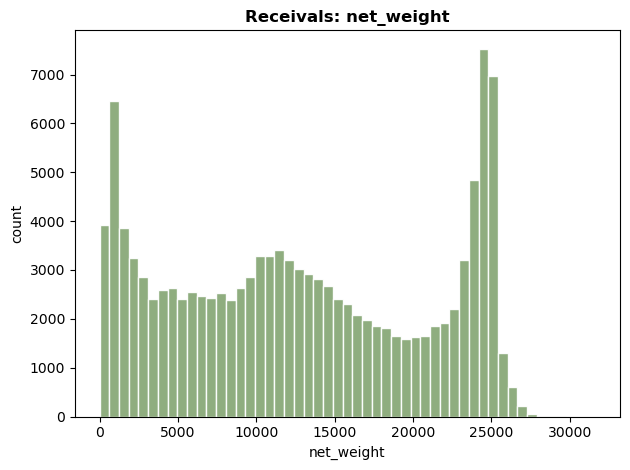

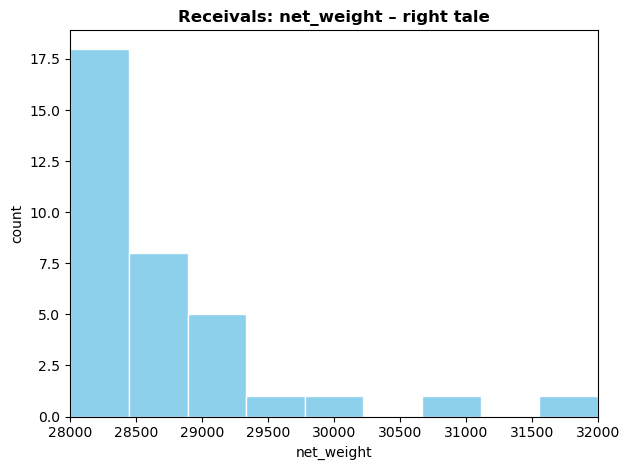

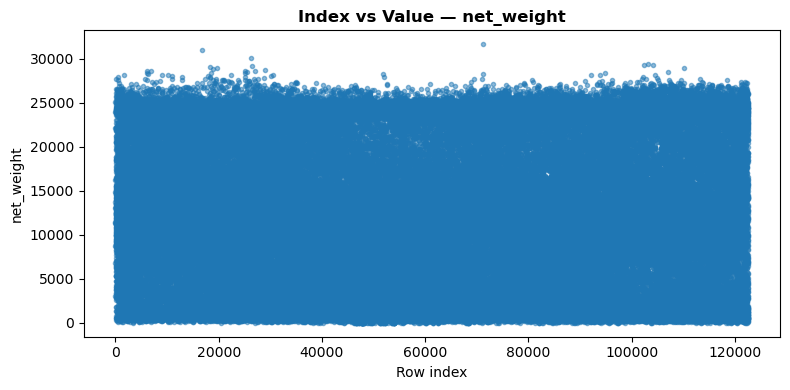

In [ ]:
recv4 = receivals.copy()

# missing net_weight
miss = recv4['net_weight'].isna().sum()
print(f"Missing net_weight: {miss:,} / {len(recv4):,} ")

# outliers
x = recv4["net_weight"]
q1, q3 = x.quantile([.25, .75])
iqr = q3 - q1
lo, hi = q1 - 0.5*iqr, q3 + 0.5*iqr  # at 0.75*iqr there were 0 outliers

mask_iqr = (x < lo) | (x > hi)           
print(f"IQR outliers: {mask_iqr.sum():,} / {len(recv4):,}  (q1={q1:.1f}, q3={q3:.1f}, lo={lo:.1f}, hi={hi:.1f})")

quantile = int((x > x.quantile(.995)).sum())
print(f"Extreme net_weight > p99.5: {quantile}")

# histogram
y = pd.to_numeric(x, errors="coerce")
plt.figure()
#plt.hist(x, bins=60)
plt.hist(
    y,
    bins="fd",                 
    color="#89a978",           
    edgecolor="white",         
    alpha=0.95
)
plt.title("Receivals: net_weight", weight="bold")
plt.xlabel("net_weight")
plt.ylabel("count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(
    y,
    bins="fd",
    color="#87CEEB",
    edgecolor="white",
    alpha=0.95,
    range=(28000, 32000)     
)
plt.xlim(28000, 32000)
plt.title("Receivals: net_weight – right tale", weight="bold")
plt.xlabel("net_weight")
plt.ylabel("count")
plt.tight_layout()
plt.show()

x = receivals["net_weight"]

plt.figure(figsize=(8,4))
plt.plot(x, '.', alpha=0.5)
plt.title("Index vs Value — net_weight", weight = "bold")
plt.xlabel("Row index")
plt.ylabel("net_weight")
plt.tight_layout()
plt.show()

Should exclude missing net_weights exclude when summing. Large peak around 2000 and 24000/25000. The distribution is bimodal.
Outliers: a short right tail up to around 29k, few extreme values. With 0.5×IQR fences, hi = q3 + 0.5·IQR ≈ 21,110 + 7,730 ≈ 28,840, only 10 outliers over that.

There’s no visible trend or step-change across the index: the cloud looks the same from row 0 to row 120k. That means nothing suspicious about file ordering (no block of weird zeros, no sudden shift).
A few very small weights exist, but they’re rare, no huge spikes beyond ~30k.

####  date_arrival, receival_status, rm_id and supplier_id

min  2004-06-15 11:34:00+00:00 | max = 2024-12-19 13:36:00+00:00
Rows with date = 122,593 / 122,593

Receival status distribution
------------------------------------------------
Completed             122448
Finished unloading       106
Start unloading           32
Planned                    4
(NA)                       3


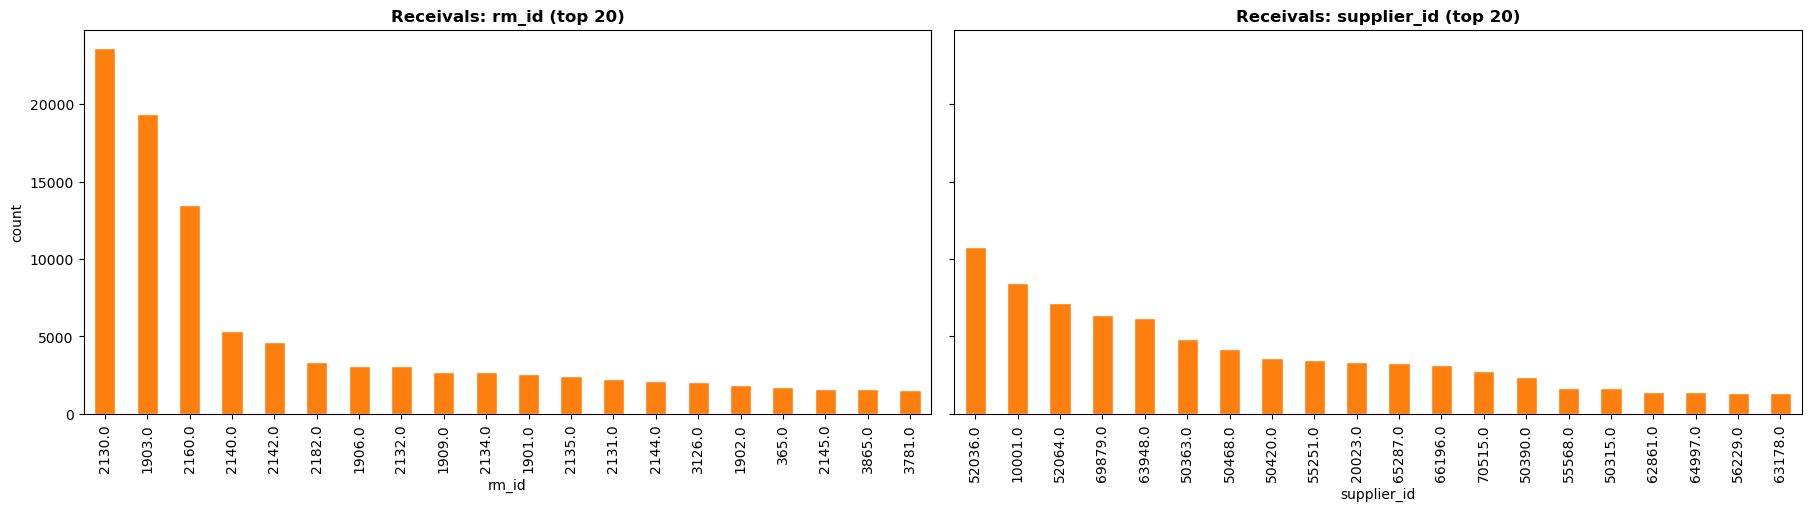

In [ ]:
recv5 = receivals.copy()
import shutil

ds = recv5["date_arrival"]
if len(ds):
    print(f"min  {ds.min()} | max = {ds.max()}")
    print(f"Rows with date = {len(ds):,} / {len(recv):,}")

n = "Receival status distribution"
print(f"\n{n}")
print("-" * (len(n) + 20))
rs = recv["receival_status"]
vc = rs.astype("object").fillna("(NA)").value_counts()
print(vc.to_string())

rm = recv5["rm_id"].astype("object").fillna("(NA)").value_counts().head(20)
sp = recv5["supplier_id"].astype("object").fillna("(NA)").value_counts().head(20)

fig, axs = plt.subplots(1, 2, figsize=(18, 5), constrained_layout=True, sharey=True)

rm.plot(kind="bar", ax=axs[0], color="#ff7f0e", edgecolor="white")
axs[0].set_title("Receivals: rm_id (top 20)", weight="bold")
axs[0].set_xlabel("rm_id")
axs[0].set_ylabel("count")
axs[0].tick_params(axis="x", labelrotation=90)

sp.plot(kind="bar", ax=axs[1], color="#ff7f0e", edgecolor="white")
axs[1].set_title("Receivals: supplier_id (top 20)", weight="bold")
axs[1].set_xlabel("supplier_id")
axs[1].tick_params(axis="x", labelrotation=90)

plt.show()

### Purchase orders

In [ ]:
prof_po = preview_feature_summary(po, "purchase_orders")


[purchase_orders] feature summary
-----------------------------------
                column               dtype  non_null%  nunique     min        q25     median        q75        max         mean          std      skew                    min_ts                    max_ts              examples
     purchase_order_id               int64 100.000000     8135     1.0   231474.0   257579.0   289944.0   331202.0 2.629573e+05 3.410719e+04 -0.256631                       NaT                       NaT                   NaN
purchase_order_item_no               int64 100.000000       94     1.0       20.0       60.0      200.0      930.0 1.346447e+02 1.608383e+02  1.652625                       NaT                       NaT                   NaN
              quantity             float64 100.000000     4997 -8580.0    10000.0    26280.0   100000.0 24975988.0 9.031416e+04 3.308047e+05 32.728669                       NaT                       NaT                   NaN
         delivery_date dateti

Quantities: handle negative and extreme values, confirm business meaning (returns, cancellations, corrections).

Both KG and PUND is used, should standardize to KG before linking to receivals/weights.

Filters for analyses: typically restrict to status in {"Open","Closed"} and positive quantities unless you’re explicitly analyzing corrections.

#### Quantity

Rows: 33,171
Q1=10000, Q3=100000, IQR=90000  |  cutoffs: hi=156120
Negatives: 6
Zeros: 4
IQR outliers: 5,709


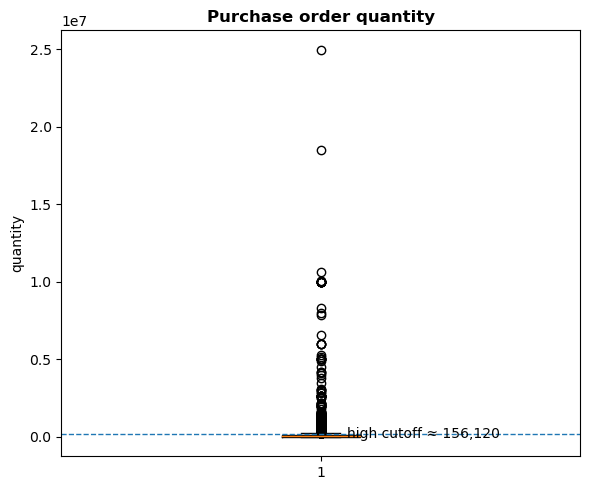

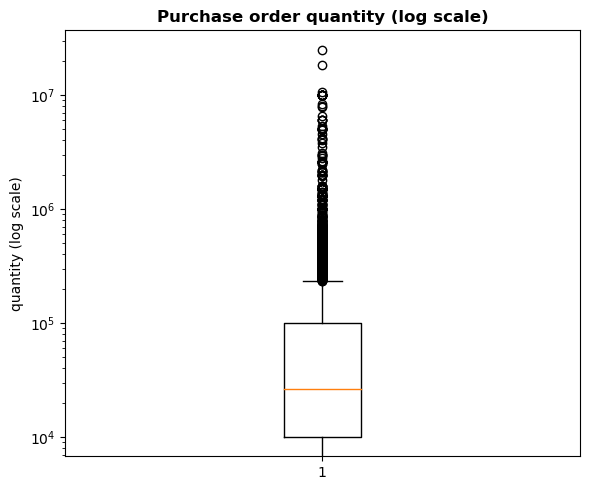

In [ ]:
po4 = purchase_orders.copy()

suspect = []
neg_mask   = po4["quantity"] < 0
zero_mask  = (po4["quantity"] == 0)

quantity = po4["quantity"]
Q1, Q3 = quantity.quantile([.25, .75])
IQR = Q3 - Q1
high = q3 + 1.5*IQR 
iqr_mask  = (po4["quantity"] > high)

suspect.extend([neg_mask, zero_mask, iqr_mask])

print(f"Rows: {len(po4):,}")
print(f"Q1={Q1:.0f}, Q3={Q3:.0f}, IQR={IQR:.0f}  |  cutoffs: hi={high:.0f}")
print(f"Negatives: {neg_mask.sum():,}")
print(f"Zeros: {zero_mask.sum():,}")
print(f"IQR outliers: {iqr_mask.sum():,}")

plt.figure(figsize=(6, 5))
plt.boxplot(quantity, vert=True, showfliers=True)
plt.title("Purchase order quantity", weight="bold")
plt.ylabel("quantity")
plt.axhline(high, linestyle="--", linewidth=1)
plt.text(1.05, high, f"high cutoff ≈ {high:,.0f}", va="center")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.boxplot(quantity, vert=True, showfliers=True)
plt.yscale("log")
plt.title("Purchase order quantity (log scale)", weight="bold")
plt.ylabel("quantity (log scale)")
plt.tight_layout()
plt.show()

The “middle” 50% of orders sits between 10k and 100k units.

Negatives: 6 rows.

Zeros: 4 rows.

In [ ]:
ds = po4["delivery_date"]
if len(ds):
    print(f"min  {ds.min()} | max = {ds.max()}")


min  2002-01-30 23:00:00+00:00 | max = 2025-06-29 22:00:00+00:00


Different coverage windows. The purchase order table goes back to 2002-01-30, while receivals start at 2004-06-15. If the warehouse/receivals system (or your extract) only has data from mid-2004 onward, any purchase order delivery dates before that will naturally have no matching receipts.

In [ ]:
t = "Purchase order status"
print(f"\n{t}")
print("-" * (len(t) + 20))
status = po4["status"]
vc = status.astype("object").fillna("(NA)").value_counts()
print(vc.to_string())


Purchase order status
-----------------------------------------
Closed     28780
Deleted     3191
Open        1200


### Transportation and materials

In [ ]:
mat = materials.copy()
trans = transportation.copy()
preview_feature_summary(mat, "materials")
preview_feature_summary(trans, "transportation", top_n=20)


[materials] feature summary
-----------------------------
                  column   dtype  non_null%  nunique    min        q25     median        q75        max         mean          std      skew                                                                                                                   examples
                   rm_id float64  99.917898      203  342.0     2133.0     2160.0     3125.0     4501.0 2.546417e+03 7.829615e+02 -0.193790                                                                                                                        NaN
              product_id float64  99.917898       54 1002.0 91900152.0 91900302.0 91901440.0 91902090.0 8.351876e+07 2.645826e+07 -2.843281                                                                                                                        NaN
         product_version float64  99.917898       65    1.0        5.0       13.0       25.0       68.0 1.642071e+01 1.318245e+01  0.942982             

,column,dtype,non_null%,nunique,min,q25,median,q75,max,mean,std,skew,examples
0,rm_id,float64,99.953504,203,342.0,1906.0,2130.0,2160.0,4501.0,2.151939e+03,5.082164e+02,0.461632,NaN
1,product_id,float64,99.953504,54,1002.0,91900143.0,91900143.0,91900302.0,91902090.0,9.137382e+07,6.935938e+06,-13.098030,NaN
2,purchase_order_id,float64,99.956766,7173,363.0,236857.0,272803.0,300251.0,331105.0,2.703605e+05,3.535135e+04,-0.099933,NaN
3,purchase_order_item_no,float64,99.956766,92,10.0,10.0,40.0,150.0,930.0,1.019654e+02,1.301033e+02,2.025080,NaN
4,receival_item_no,int64,100.000000,15,0.0,1.0,1.0,2.0,14.0,1.448161e+00,8.467539e-01,2.427058,NaN
5,batch_id,float64,52.830573,64765,43903.0,746268.0,892069.0,1041403.0,1178438.0,8.898592e+05,1.719868e+05,-0.075880,NaN
6,transporter_name,object,100.000000,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transporter0, Transporter1, Transporter2, Tran..."
7,vehicle_no,object,100.000000,17029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Vehicle0, Vehicle1, Vehicle2, Vehicle3, Vehicle4"
8,unit_status,object,99.993474,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Transferred, Accepted, Pending, Rejected, Canc..."
9,vehicle_start_weight,float64,99.983685,2204,698.0,30460.0,35560.0,39720.0,60720.0,3.457273e+04,5.733303e+03,-0.807551,NaN


### Weight over months

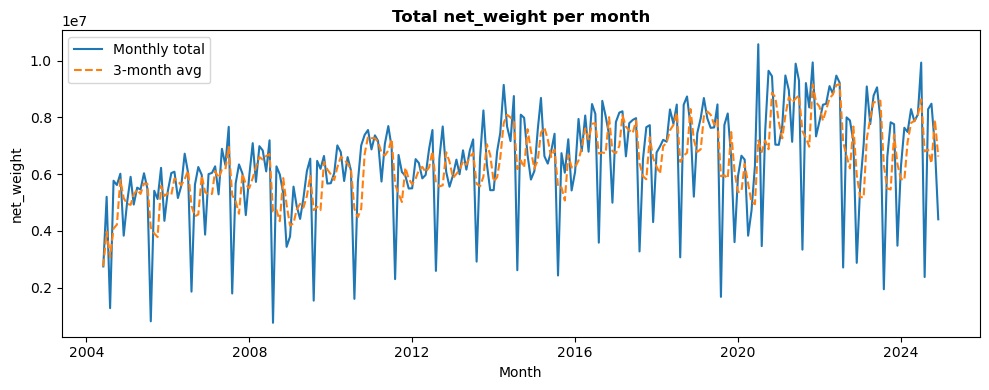

In [ ]:
df = receivals.copy()
df["date_arrival"] = pd.to_datetime(df["date_arrival"], utc=True, errors="coerce")
df["net_weight"]   = pd.to_numeric(df["net_weight"], errors="coerce")

monthly = (
    df.set_index("date_arrival")
      .resample("MS")["net_weight"]
      .sum(min_count=1)
)

roll3 = monthly.rolling(3, min_periods=1).mean()

plt.figure(figsize=(10,4))
plt.plot(monthly.index, monthly.values, label="Monthly total")
plt.plot(roll3.index, roll3.values, linestyle="--", label="3-month avg")
plt.title("Total net_weight per month", weight = "bold")
plt.xlabel("Month")
plt.ylabel("net_weight")
plt.legend()
plt.tight_layout()
plt.show()

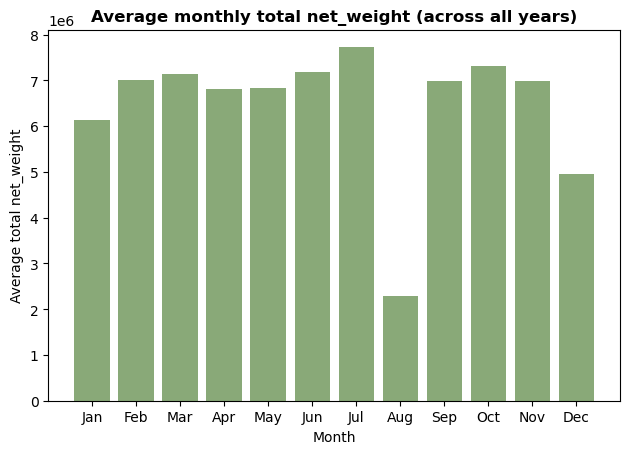

In [ ]:
m = receivals.copy()
m["date_arrival"] = pd.to_datetime(m["date_arrival"], utc=True, errors="coerce")
m["net_weight"] = pd.to_numeric(m["net_weight"], errors="coerce")

by_moy_avg = (
    m.set_index("date_arrival")["net_weight"]
     .resample("MS").sum()
     .groupby(lambda d: d.month).mean()
     .reindex(range(1,13))
)

month_names = [pd.Timestamp(2000, m, 1).strftime("%b") for m in range(1,13)]
plt.bar(month_names, by_moy_avg.values, color="#89a978")
plt.title("Average monthly total net_weight (across all years)", weight = "bold")
plt.xlabel("Month"); plt.ylabel("Average total net_weight")
plt.tight_layout(); plt.show()

## 5. Explore Pairs and Groups of Features


- Ordered vs Received (before/after timing-fair) with side-by-side tables
- Split shipments vs completion time (+ under-fulfil by split bin)
- Shipment size CV (materials, top suppliers)
- Supplier reliability (cleaned delays)
- Correlation heatmap


### 1. Parse dates & join → rec_po

In [ ]:
plt.rcParams["figure.figsize"] = (9, 4)
plt.rcParams.update({
    "axes.titlesize": 12,   
    "axes.labelsize": 10,   
    "xtick.labelsize": 9,  
    "ytick.labelsize": 9,
    "legend.fontsize": 8,
})

receivals = receivals[receivals["net_weight"] > 0].copy()

rec_po = receivals.merge(
    purchase_orders[[
        "purchase_order_id","purchase_order_item_no","quantity","delivery_date","product_id","product_version"
    ]],
    on=["purchase_order_id","purchase_order_item_no"],
    how="left"
)
print("rec_po rows:", len(rec_po))


rec_po rows: 122386


### 4. Placeholder cleanup → rec_base & rec_clean

In [ ]:
# Make tz-naive day fields
rec_base = rec_po.copy()
rec_base["arrival_day"]  = rec_base["date_arrival"].dt.tz_convert(None).dt.floor("D")
rec_base["delivery_day"] = rec_base["delivery_date"].dt.tz_convert(None).dt.floor("D")

# Flag placeholders: end-of-month expected dates (includes Dec 31 / year-end)
rec_base["placeholder"] = rec_base["delivery_day"].dt.is_month_end

# Raw delay for reference
rec_base["delay_raw"] = (rec_base["arrival_day"] - rec_base["delivery_day"]).dt.days

# Cleaned view = remove placeholder rows for delay analysis
rec_clean = rec_base[~rec_base["placeholder"]].copy()
rec_clean["delay_days"] = rec_clean["delay_raw"]  # canonical delay column for all delay plots

print("Placeholder rate:", rec_base["placeholder"].mean())
print("Median delay raw / clean:", np.nanmedian(rec_base["delay_raw"]), "/", np.nanmedian(rec_clean["delay_days"]))
print("On-time share raw / clean:", (rec_base["delay_raw"]<=0).mean(), "/", (rec_clean["delay_days"]<=0).mean())


Placeholder rate: 0.003015050741097838
Median delay raw / clean: -14.0 / -14.0
On-time share raw / clean: 0.8893092347163891 / 0.8902284107952171


### 5. Ordered vs. Received 

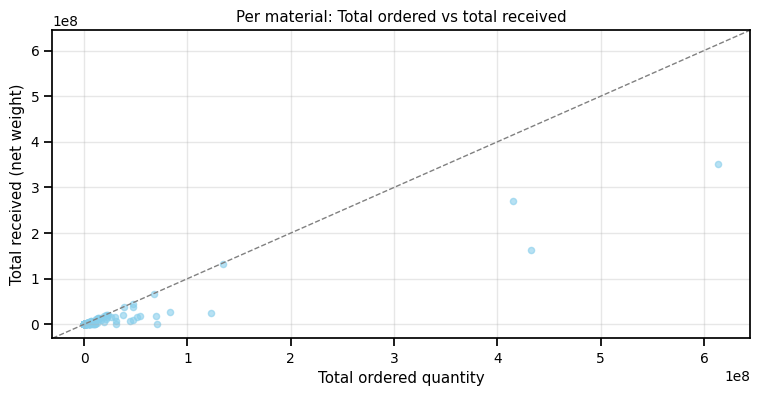

Worst fulfilment ratios (Top 10, min order ≥ 1,000,000):
 rm_id  rm_total_ordered  rm_total_received  ratio
 387.0         1001080.0             1780.0  0.002
 381.0        30642304.0            60954.0  0.002
 383.0         3163240.0             6310.0  0.002
 380.0        10011000.0            21000.0  0.002
 360.0         1110922.0             3535.0  0.003
 345.0         6575000.0            22780.0  0.003
 343.0         4530000.0            21760.0  0.005
 378.0         4276000.0            26608.0  0.006
 348.0         6575000.0            48620.0  0.007
 362.0         8279160.0            70090.0  0.008


In [ ]:
# Per-material totals 
rm_received = (rec_po.groupby("rm_id", as_index=False)["net_weight"]
                   .sum()
                   .rename(columns={"net_weight":"rm_total_received"}))

rm_unique_po = rec_po.drop_duplicates(["rm_id","purchase_order_id","purchase_order_item_no"])
rm_ordered   = (rm_unique_po.groupby("rm_id", as_index=False)["quantity"]
                           .sum()
                           .rename(columns={"quantity":"rm_total_ordered"}))

rm_level = (rm_received.merge(rm_ordered, on="rm_id", how="outer")
                      .fillna(0))

rm_level["rm_fulfilment_ratio"] = np.where(
    rm_level["rm_total_ordered"] > 0,
    rm_level["rm_total_received"] / rm_level["rm_total_ordered"],
    np.nan
)
rm_level["gap"] = rm_level["rm_total_ordered"] - rm_level["rm_total_received"]

# Scatter: ordered vs received (per material)
x = rm_level["rm_total_ordered"].to_numpy()
y = rm_level["rm_total_received"].to_numpy()

ax = rm_level.plot.scatter(x="rm_total_ordered", y="rm_total_received", alpha=0.6, color="skyblue")
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1]),
]
ax.plot(lims, lims, ls="--", lw=1, color="gray")
ax.set_xlim(lims); ax.set_ylim(lims)
ax.set_title("Per material: Total ordered vs total received")
ax.set_xlabel("Total ordered quantity"); ax.set_ylabel("Total received (net weight)")
plt.grid(True, alpha=0.3); plt.show()

# Worst fulfilment ratios 
TOP_N = 10
MIN_ORDER = 1_000_000

worst_ratio = (rm_level.loc[rm_level["rm_total_ordered"] >= MIN_ORDER,
                            ["rm_id","rm_total_ordered","rm_total_received","rm_fulfilment_ratio"]]
                        .rename(columns={"rm_fulfilment_ratio":"ratio"})
                        .sort_values("ratio", na_position="last")
                        .head(TOP_N))

worst_ratio["ratio"] = worst_ratio["ratio"].round(3)

print(f"Worst fulfilment ratios (Top {TOP_N}, min order ≥ {MIN_ORDER:,}):")
print(worst_ratio.to_string(index=False))

The scatter compares total ordered (x) vs. total received (y) per material; the dashed 45° line marks perfect fulfilment. Most materials are low-volume near the origin, while several high-volume materials fall below the line, indicating notable under-fulfilment. This may reflect true shortfalls or simply timing (orders not yet due/received within our window). 

From the table, the three worst performers are rm_id 387, 381, and 383.

### 6. Split-shipments vs completion time (+ under-fulfil by split bin)

/var/folders/1g/0sfrhqy137s9pstl_0g_bzkh0000gn/T/ipykernel_16507/2756866208.py:26: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(completion_day_for_item).rename("completion_day").reset_index())


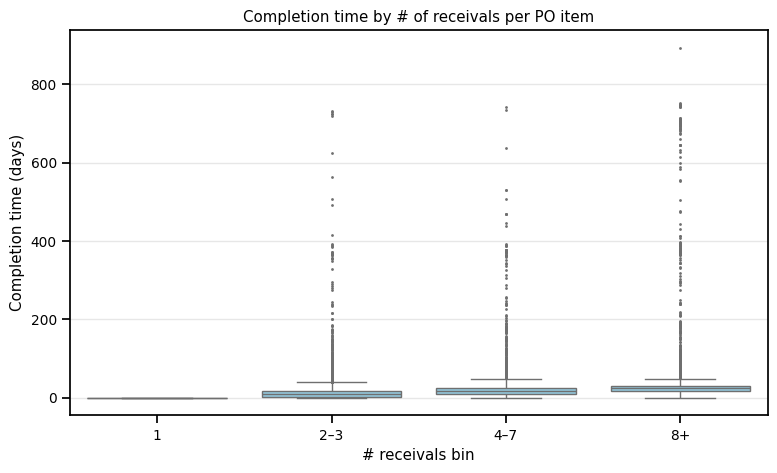

/var/folders/1g/0sfrhqy137s9pstl_0g_bzkh0000gn/T/ipykernel_16507/2756866208.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uf = (po_item_panel.groupby("split_bin")["under_fulfil"]


,split_bin,under_fulfil_share
0,1,0.62
1,2–3,0.56
2,4–7,0.57
3,8+,0.64


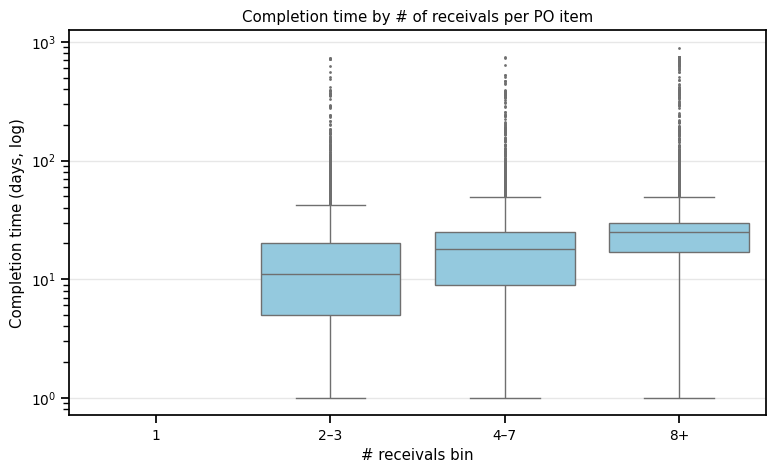

In [ ]:
rec = rec_po.copy()
rec["arrival_day"]  = rec["date_arrival"].dt.tz_convert(None).dt.floor("D")
rec["delivery_day"] = rec["delivery_date"].dt.tz_convert(None).dt.floor("D")

po_qty = (rec.drop_duplicates(["purchase_order_id","purchase_order_item_no"])
            .set_index(["purchase_order_id","purchase_order_item_no"])["quantity"])

g = rec.sort_values("arrival_day").groupby(["purchase_order_id","purchase_order_item_no"])
n_recv = g.size().rename("n_receivals")

rec_seq = (rec.sort_values("arrival_day")
             .groupby(["purchase_order_id","purchase_order_item_no","arrival_day"])["net_weight"]
             .sum().groupby(level=[0,1]).cumsum().rename("cum_received").reset_index())

first_last = g["arrival_day"].agg(first_arrival="min", last_arrival="max")

def completion_day_for_item(df):
    key = (df["purchase_order_id"].iloc[0], df["purchase_order_item_no"].iloc[0])
    ord_qty = po_qty.loc[key] if key in po_qty.index else np.nan
    if pd.isna(ord_qty):
        return pd.NaT
    reached = df[df["cum_received"] >= ord_qty]
    return reached["arrival_day"].iloc[0] if not reached.empty else df["arrival_day"].iloc[-1]

comp = (rec_seq.groupby(["purchase_order_id","purchase_order_item_no"])
              .apply(completion_day_for_item).rename("completion_day").reset_index())

po_item_panel = (first_last
                 .merge(n_recv, left_index=True, right_index=True)
                 .reset_index()
                 .merge(comp, on=["purchase_order_id","purchase_order_item_no"], how="left")
                 .merge(po_qty.rename("ordered"), left_on=["purchase_order_id","purchase_order_item_no"], right_index=True, how="left"))

po_item_panel["completion_time_days"] = (po_item_panel["completion_day"] - po_item_panel["first_arrival"]).dt.days

po_item_panel["split_bin"] = pd.cut(
    po_item_panel["n_receivals"],
    bins=[0,1,3,7,1e9],
    labels=["1","2–3","4–7","8+"],
    right=True
)

final_received = (rec.groupby(["purchase_order_id","purchase_order_item_no"])["net_weight"].sum().rename("received_final"))
po_item_panel = po_item_panel.merge(final_received, on=["purchase_order_id","purchase_order_item_no"], how="left")
po_item_panel["under_fulfil"] = po_item_panel["received_final"] < po_item_panel["ordered"]

plt.figure(figsize=(9,5))
sns.boxplot(data=po_item_panel.dropna(subset=["split_bin","completion_time_days"]),
            x="split_bin", y="completion_time_days", fliersize=1, color="skyblue")
plt.title("Completion time by # of receivals per PO item")
plt.xlabel("# receivals bin"); plt.ylabel("Completion time (days)")
plt.grid(True, axis="y", alpha=0.3); plt.show()

uf = (po_item_panel.groupby("split_bin")["under_fulfil"]
      .mean().rename("under_fulfil_share").reset_index())
display(uf.style.format({"under_fulfil_share":"{:.2f}"}).set_caption("Under-fulfil share by split bin"))

plot_df = po_item_panel.dropna(subset=["split_bin","completion_time_days"]).query("completion_time_days > 0")

plt.figure(figsize=(9,5))
sns.boxplot(data=plot_df, x="split_bin", y="completion_time_days", fliersize=1, color="skyblue")
plt.yscale("log")  # <- log scale
plt.title("Completion time by # of receivals per PO item")
plt.xlabel("# receivals bin"); plt.ylabel("Completion time (days, log)")
plt.grid(True, axis="y", alpha=0.3)
plt.show()



More splits → slower completion. PO items delivered in one receival finish fastest. As the number of receivals grows (2–3 → 4–7 → 8+), the median completion time increases and the tail gets much longer (some items take many months). 

Implication: items split into many parts (or oddly, single-drop items) are riskier; they take longer and are more likely to end below the ordered quantity. 

### 7. Shipment-size CV (materials & top suppliers)

,rm_id,n,mean,std,cv
62,1981.000000,21,"3,280","5,064",1.54
110,2283.000000,11,"6,861","9,503",1.39
163,3421.000000,349,"2,094","2,898",1.38
44,1867.000000,15,"2,646","3,443",1.30
77,2132.000000,"3,099","4,001","5,047",1.26
86,2143.000000,"1,368","2,381","2,890",1.21
87,2144.000000,"2,104","4,372","5,224",1.19
56,1904.000000,"1,484","4,563","5,393",1.18
89,2146.000000,411,"5,292","6,036",1.14
88,2145.000000,"1,627","3,219","3,630",1.13


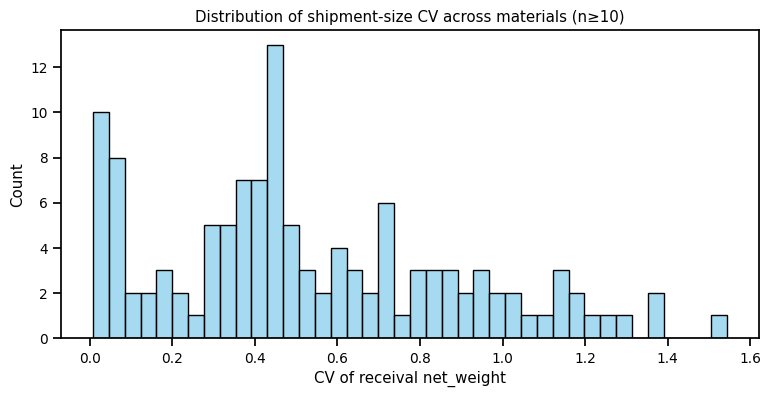

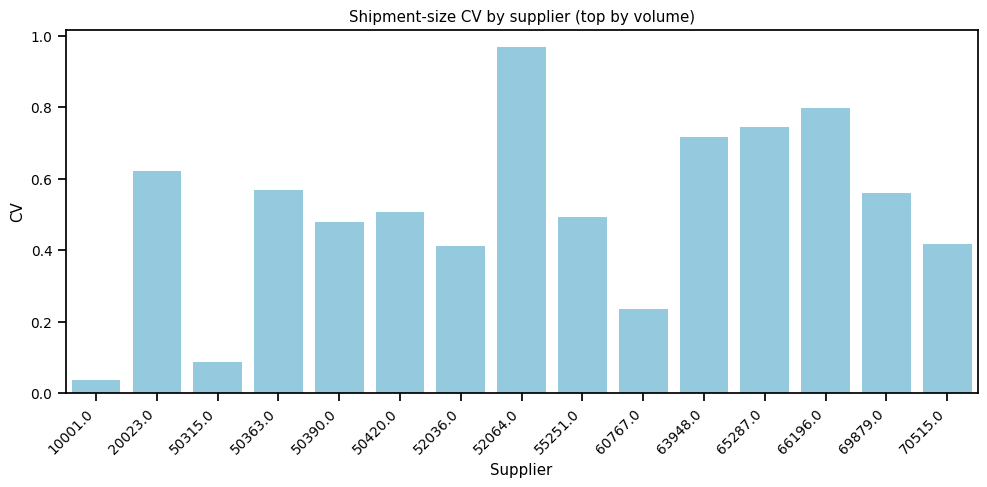

In [ ]:
# Materials
rm_stats = (rec_po.groupby("rm_id")["net_weight"].agg(n="count", mean="mean", std="std")).reset_index()
rm_stats["cv"] = rm_stats["std"] / rm_stats["mean"]
rm_stats = rm_stats.replace([np.inf,-np.inf], np.nan)
rm_stats_filt = rm_stats[rm_stats["n"] >= 10].sort_values("cv", ascending=False)

display(rm_stats_filt.head(15).style.format({"mean":"{:,.0f}", "std":"{:,.0f}", "cv":"{:.2f}", "n":"{:,.0f}"})
        .set_caption("Highest shipment-size CV (materials, n≥10)"))

plt.figure(figsize=(9,4))
sns.histplot(rm_stats_filt["cv"].dropna(), bins=40, color="skyblue")
plt.title("Distribution of shipment-size CV across materials (n≥10)")
plt.xlabel("CV of receival net_weight"); plt.ylabel("Count")
plt.show()

# Suppliers (top by delivered volume)
topN = 15
top_suppliers = (rec_po.groupby("supplier_id")["net_weight"].sum()
                 .sort_values(ascending=False).head(topN).index)

sup_stats_cv = (rec_po[rec_po["supplier_id"].isin(top_suppliers)]
                .groupby("supplier_id")["net_weight"]
                .agg(n="count", mean="mean", std="std")).reset_index()
sup_stats_cv["cv"] = sup_stats_cv["std"] / sup_stats_cv["mean"]

plt.figure(figsize=(10,5))
sns.barplot(data=sup_stats_cv.sort_values("cv", ascending=False),
            x="supplier_id", y="cv", color="skyblue")
plt.title("Shipment-size CV by supplier (top by volume)")
plt.xlabel("Supplier"); plt.ylabel("CV")
plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


Top-CV materials (table): some materials have CV ≈ 1.0–1.5 (e.g., rm_id ~1981, 2283, 3421). That means their shipment-size std is about the same as, or larger than, the mean: very inconsistent lot sizes.

Histogram (materials, n≥10): most materials sit around CV 0.3–0.7, with a long tail above 0.8–1.0. A practical rule: CV > 0.8 = high variability (riskier to forecast).

Supplier bar chart (top by volume): suppliers differ a lot. Some are stable (CV ≈ 0.05–0.25), while others are volatile (CV ≈ 0.7–0.95). High-CV suppliers will make inflow lumpier and should push forecasts to be more conservative.

### 3. Supplier reliability (using cleaned delays)

/var/folders/1g/0sfrhqy137s9pstl_0g_bzkh0000gn/T/ipykernel_16507/1135186809.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sup_top["delay_days_clipped"] = sup_top["delay_days"].clip(lower=-30, upper=120)


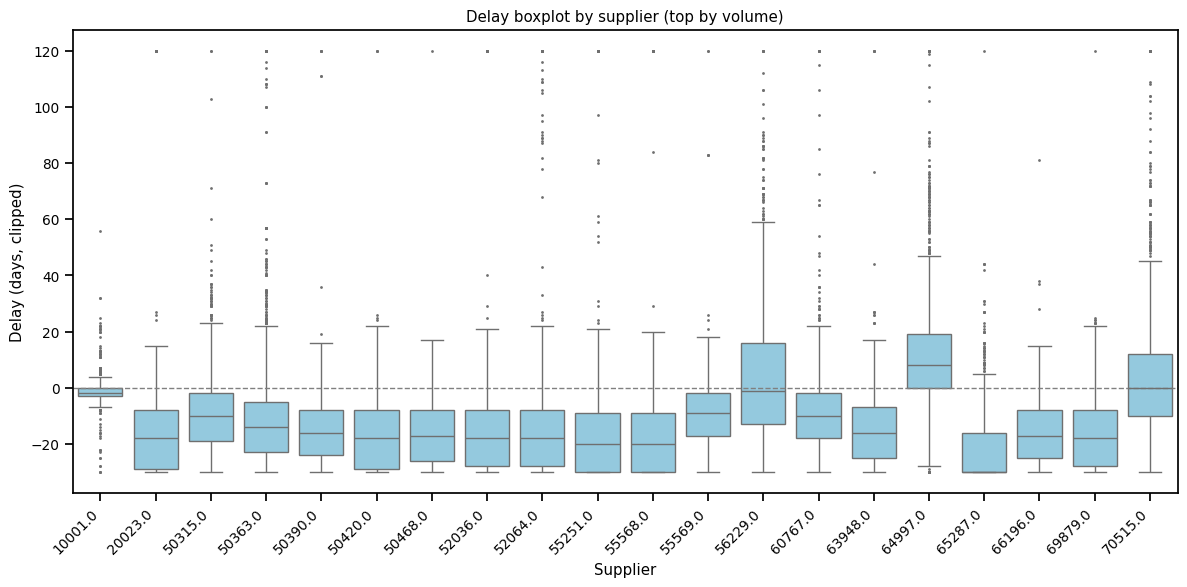

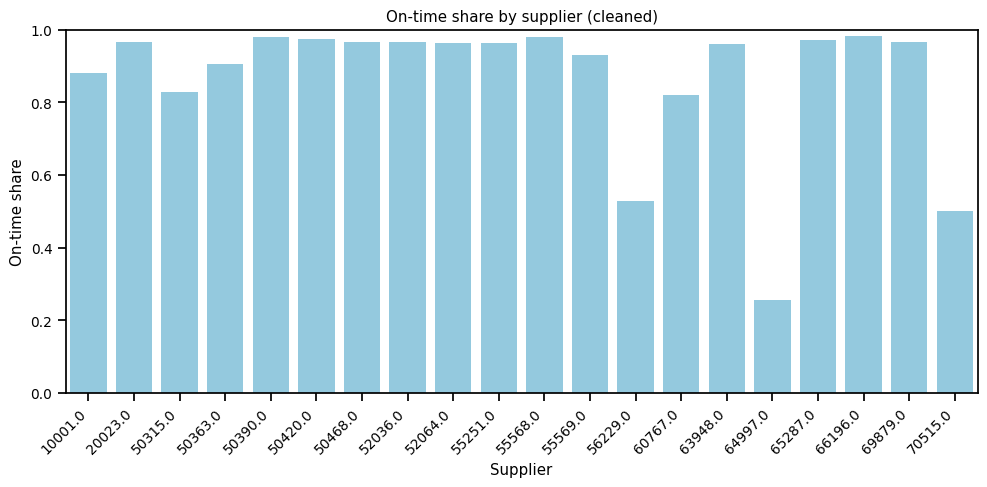

In [ ]:
sup = rec_clean.copy()

# PO-item fulfilment 
po_item = (sup.groupby(["purchase_order_id","purchase_order_item_no"])
             .agg(ordered=("quantity","first"), received=("net_weight","sum")).reset_index())
po_item["fulfil"] = po_item["received"]/po_item["ordered"]
sup = sup.merge(po_item, on=["purchase_order_id","purchase_order_item_no"], how="left")

sup_stats = (sup.groupby("supplier_id")
  .agg(n=("net_weight","count"),
       on_time=("delay_days", lambda s: (s<=0).mean()),
       med_delay=("delay_days","median"),
       under_fulfil=("fulfil", lambda s: (s<1).mean()))
  .reset_index())

topN = 20
top_suppliers = (sup.groupby("supplier_id")["net_weight"].sum()
                 .sort_values(ascending=False).head(topN).index)
sup_top = sup[sup["supplier_id"].isin(top_suppliers)]
sup_stats_top = sup_stats[sup_stats["supplier_id"].isin(top_suppliers)]
sup_top["delay_days_clipped"] = sup_top["delay_days"].clip(lower=-30, upper=120)

# Delay boxplot
plt.figure(figsize=(12,6))
sns.boxplot(data=sup_top, x="supplier_id", y="delay_days_clipped", fliersize=1, color="skyblue")
plt.axhline(0, ls="--", lw=1, color="gray")
plt.title("Delay boxplot by supplier (top by volume)")
plt.xlabel("Supplier"); plt.ylabel("Delay (days, clipped)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout(); plt.show()

# On-time share bar
plt.figure(figsize=(10,5))
sns.barplot(data=sup_stats_top.sort_values("on_time", ascending=False),
            x="supplier_id", y="on_time", color="skyblue")
plt.title("On-time share by supplier (cleaned)")
plt.xlabel("Supplier"); plt.ylabel("On-time share")
plt.ylim(0,1); plt.xticks(rotation=45, ha="right"); plt.tight_layout(); plt.show()


Most top suppliers deliver earlier than the expected date (medians below 0), but many still have occasional big delays (the tall outliers). A few suppliers have medians around or above 0 and much wider spreads, these look less reliable and are more likely to be late. 

### 9. Correlation heatmap

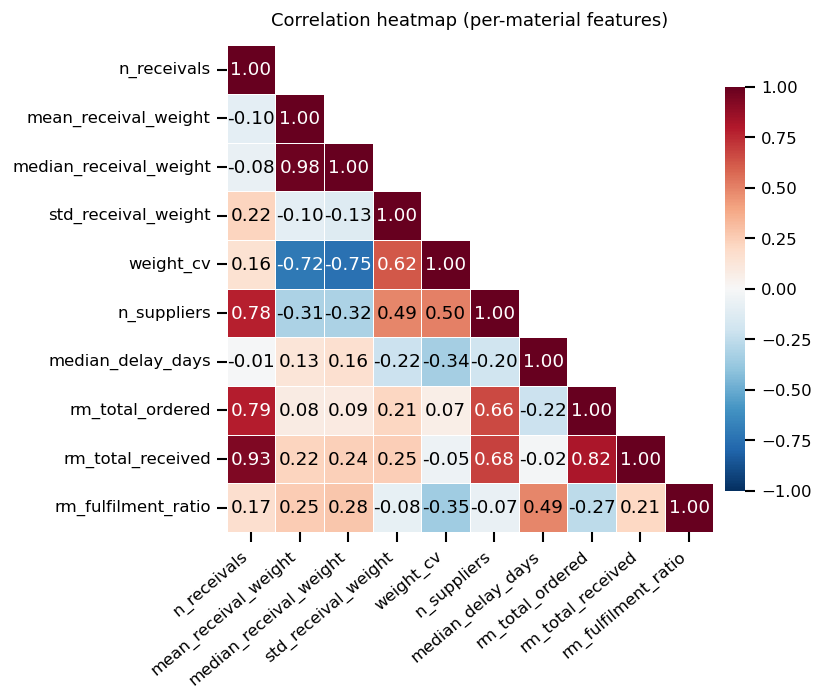

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

sns.set_context("notebook", font_scale=0.9)
fig, ax = plt.subplots(figsize=(7, 6), dpi=120)

hm = sns.heatmap(
    corr,
    mask=mask,
    cmap="RdBu_r",        # diverging, centered at 0
    vmin=-1, vmax=1, center=0,
    annot=True, fmt=".2f",
    annot_kws={"size":11},
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink":0.8, "pad":0.02}
)

ax.set_title("Correlation heatmap (per-material features)", pad=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

# Make annotation text switch color for contrast
for txt in ax.texts:
    try:
        val = float(txt.get_text())
    except ValueError:
        continue
    txt.set_color("white" if abs(val) > 0.6 else "black")

plt.tight_layout()
plt.show()

Total received is driven mostly by volume proxies: the number of receivals has the strongest association with received (very high), and total ordered also correlates strongly. Materials sourced from more suppliers tend to receive more overall (moderate–strong link). In contrast, shipment-size statistics (mean/median weight per receival) and size variability (CV) show only weak relationships with total received, and delay is essentially unrelated to the final quantity.

## 6. Clean Up Features

# **Feature Engineering**